# ISOT EDA

# EDA Notebook
This notebook performs quick, *reproducible* EDA for the dataset.
- Safe defaults (no heavy cleaning)
- Visual checks for class balance & text length
- Duplicate checks
- Top n-grams per class
- (ISOT only) Leakage probes (title-only & subject-only)
> Charts use matplotlib (no seaborn).


In [4]:
# Basic setup
import os, sys, math, json, textwrap, re, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# inline plotting
%matplotlib inline

# Utility: show simple stats for a text column
def text_length_stats(series):
    lengths = series.fillna("").astype(str).apply(lambda s: len(s.split()))
    return {
        "count": lengths.size,
        "min": int(lengths.min() if lengths.size else 0),
        "p25": float(np.percentile(lengths, 25)) if lengths.size else 0,
        "median": float(np.percentile(lengths, 50)) if lengths.size else 0,
        "p75": float(np.percentile(lengths, 75)) if lengths.size else 0,
        "max": int(lengths.max() if lengths.size else 0),
        "mean": float(lengths.mean()) if lengths.size else 0,
        "std": float(lengths.std()) if lengths.size else 0,
    }

def plot_hist(lengths, title):
    plt.figure(figsize=(6,4))
    plt.hist(lengths, bins=50)
    plt.title(title)
    plt.xlabel("Token count")
    plt.ylabel("Frequency")
    plt.show()

def top_ngrams(df, text_col, label_col=None, label_value=None, n=20, ngram_range=(1,2), min_df=5, max_df=0.95):
    from sklearn.feature_extraction.text import CountVectorizer
    # optional class slice
    if label_col is not None and label_value is not None:
        df = df[df[label_col] == label_value]
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=max_df)
    X = vec.fit_transform(df[text_col].fillna("").astype(str))
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    order = np.argsort(freqs)[::-1][:n]
    return list(zip(vocab[order], freqs[order].astype(int)))


In [8]:
# Set file paths (edit if needed)
TRUE_CSV = "../data/raw/True.csv"
FAKE_CSV = "../data/raw/Fake.csv"

assert os.path.exists(TRUE_CSV), f"Missing {TRUE_CSV}"
assert os.path.exists(FAKE_CSV), f"Missing {FAKE_CSV}"


In [9]:
# Load & basic schema checks
true = pd.read_csv(TRUE_CSV)
fake = pd.read_csv(FAKE_CSV)

true["label"] = 1
fake["label"] = 0
df = pd.concat([true, fake], ignore_index=True)

expected_cols = {"title","text","subject","date","label"}
print("Columns:", list(df.columns))
missing = expected_cols.difference(df.columns)
if missing:
    print("WARNING: missing columns ->", missing)

print("Shape:", df.shape)
df.sample(3)


Columns: ['title', 'text', 'subject', 'date', 'label']
Shape: (44898, 5)


,title,text,subject,date,label
28256,Ted Cruz Is Forced To Explain His Bigotry To ...,A gay man cornered Ted Cruz on Monday and the ...,News,"April 18, 2016",0
40092,#NewOrleans: BLACK PATRIOTS Ready To Fight Ant...,May 7th is likely going to be a day of clashes...,left-news,"May 7, 2017",0
20061,France to make armed street patrols more rando...,PARIS (Reuters) - France will make the armed s...,worldnews,"September 14, 2017",1


Class balance (0=fake, 1=true):
 label
0    23481
1    21417
Name: count, dtype: int64 

Text length stats: {'count': 44898, 'min': 0, 'p25': 203.0, 'median': 362.0, 'p75': 513.0, 'max': 8135, 'mean': 405.28228428883244, 'std': 351.26559488349176}
Title length stats: {'count': 44898, 'min': 1, 'p25': 10.0, 'median': 11.0, 'p75': 14.0, 'max': 42, 'mean': 12.453472315025168, 'std': 4.11147564631567}


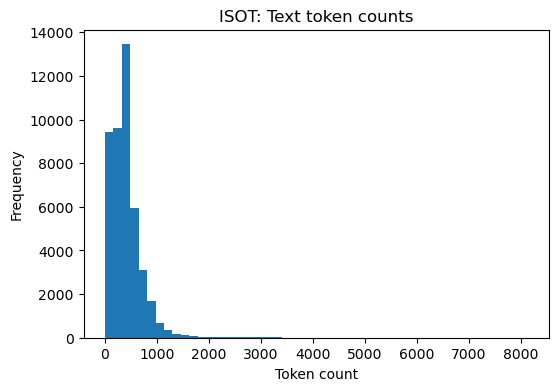

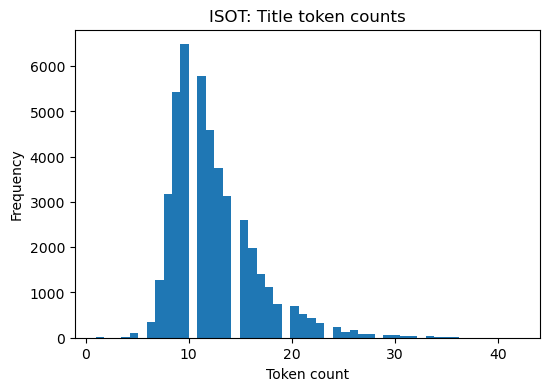

In [10]:
# Class balance & length stats
bal = df["label"].value_counts().sort_index()
print("Class balance (0=fake, 1=true):\n", bal, "\n")

text_lengths = df["text"].fillna("").astype(str).apply(lambda s: len(s.split()))
title_lengths = df["title"].fillna("").astype(str).apply(lambda s: len(s.split()))

print("Text length stats:", text_length_stats(df["text"]))
print("Title length stats:", text_length_stats(df["title"]))

# Plots
plot_hist(text_lengths, "ISOT: Text token counts")
plot_hist(title_lengths, "ISOT: Title token counts")


In [11]:
# Duplicate / near-duplicate checks
# Exact duplicates
def duplicate_report(df, id_col, text_col):
    s = df[text_col].fillna("").astype(str)
    duplicates = s.duplicated(keep=False)
    dup_df = df[duplicates].copy()
    dup_groups = dup_df.groupby(s).size().sort_values(ascending=False)
    print(f"Exact-duplicate texts: {int(duplicates.sum())} / {len(df)}")
    return dup_df, dup_groups.head(10)


dup_df, dup_groups = duplicate_report(df, id_col=None, text_col="text")
dup_groups


Exact-duplicate texts: 11392 / 44898


text
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [12]:
# Subject distribution & chi-square (requires scipy)
subj_counts = df["subject"].value_counts().head(15)
print("Top subjects:\n", subj_counts, "\n")

try:
    import scipy.stats as stats
    ct = pd.crosstab(df["subject"], df["label"])
    chi2, p, dof, exp = stats.chi2_contingency(ct)
    print(f"Chi-square(label vs subject): chi2={chi2:.2f}, dof={dof}, p={p:.3g}")
except Exception as e:
    print("Chi-square skipped (install scipy). Error:", e)


Top subjects:
 subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64 

Chi-square(label vs subject): chi2=44898.00, dof=7, p=0


In [13]:
# Top n-grams overall and per class
overall = top_ngrams(df, text_col="text", n=20, ngram_range=(1,2), min_df=10)
fake_ngrams = top_ngrams(df, text_col="text", label_col="label", label_value=0, n=20)
true_ngrams = top_ngrams(df, text_col="text", label_col="label", label_value=1, n=20)

print("Top overall ngrams:", overall[:10])
print("\nTop FAKE ngrams:", fake_ngrams[:10])
print("\nTop TRUE ngrams:", true_ngrams[:10])


Top overall ngrams: [('to', 536553), ('of', 441915), ('and', 409052), ('in', 352815), ('that', 239899), ('on', 192185), ('for', 173375), ('is', 166728), ('trump', 134000), ('he', 133367)]

Top FAKE ngrams: [('the', 543551), ('to', 290819), ('of', 236640), ('and', 226971), ('in', 171163), ('that', 151662), ('is', 111234), ('for', 93480), ('on', 83591), ('it', 83380)]

Top TRUE ngrams: [('and', 182081), ('said', 99062), ('that', 88237), ('for', 79895), ('is', 55494), ('trump', 54700), ('with', 54504), ('he', 54370), ('it', 49590), ('by', 47949)]


In [14]:
# Leakage probe: title-only & subject-only
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

train, temp = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp["label"], random_state=42)

# Title-only
pipe_title = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.95),
    LogisticRegression(max_iter=200, class_weight="balanced")
)
pipe_title.fit(train["title"].fillna(""), train["label"])
pred = pipe_title.predict(test["title"].fillna(""))
print("TITLE-ONLY baseline")
print(classification_report(test["label"], pred, digits=3))

# Subject-only (treat subject as tiny text)
pipe_subject = make_pipeline(
    TfidfVectorizer(),  # tiny vocab, ok
    LogisticRegression(max_iter=200, class_weight="balanced")
)
pipe_subject.fit(train["subject"].fillna(""), train["label"])
pred2 = pipe_subject.predict(test["subject"].fillna(""))
print("SUBJECT-ONLY baseline")
print(classification_report(test["label"], pred2, digits=3))


TITLE-ONLY baseline
              precision    recall  f1-score   support

           0      0.969     0.947     0.958      2348
           1      0.943     0.966     0.955      2142

    accuracy                          0.956      4490
   macro avg      0.956     0.957     0.956      4490
weighted avg      0.956     0.956     0.956      4490

SUBJECT-ONLY baseline
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      2348
           1      1.000     1.000     1.000      2142

    accuracy                          1.000      4490
   macro avg      1.000     1.000     1.000      4490
weighted avg      1.000     1.000     1.000      4490

